# Probability & Statistics 7

## Monty Hall Problem

How do we solve this in Python? The textbook uses an objected oriented approach - we will use a non-OO approach to aid understanding.


In [12]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pprint


# Likelihood function of observating data given hypothesis h is true
# In this case, there is only one kind of data observed, 
# hence no need to take data as input
# The data consists of two parts: Monty chooses Door B 
# AND there is no car there.
def Likelihood(h):
    # If the car is actually behind A, Monty could safely open Doors B or
    # C. So the probability that he chooses B is 1/2. And since the car is
    # actually behind A, the probability that the car is not behind B is 1.
    if h=='A':
        return 0.5
    # If the car is actually behind B, Monty has to open door C, so the probability
    # that he opens door B is 0.
    if h=='B':
        return 0 
    # Finally, if the car is behind Door C, Monty opens B with probability 1
    # and finds no car there with probability 1.
    if h=='C':
        return 1.0
    
def update(hpmf):
    total = 0.0
    # multiply prior by likelihood
    for h in hpmf.keys():
        hpmf[h] *= Likelihood(h)
        total += hpmf[h]
    # normalize to sum to 1.0
    for h in hpmf.keys():
        hpmf[h] /= total

# Define the prior probability over the hypotheses
# A = car is behind door A etc.
hypothesisPMF = {'A':0.33,'B':0.33, 'C':0.34}

# Do the bayesian update to get the posterior probabilities
update(hypothesisPMF)
pprint.pprint(hypothesisPMF)



{'A': 0.32673267326732675, 'B': 0.0, 'C': 0.6732673267326733}


## Geiger Counter Problem (TB Ch.14)

Suppose that a radioactive source emits particles toward a
Geiger counter at an average rate of r particles per second, but
the counter only registers a fraction, f , of the particles that hit
it. If f is 10% and the counter registers 15 particles in a one second
interval, what is the posterior distribution of n, the actual
number of particles that hit the counter, and r, the average rate
particles are emitted?

Assume rate of emission r and measured counts by the Geiger counter are known.
Find n, the actual number of particles that hit the counter.

Observing k = 20
MAP estimate for n = 64
Observing k = 30
MAP estimate for n = 83
Observing k = 30
MAP estimate for n = 96
Observing k = 28
MAP estimate for n = 106


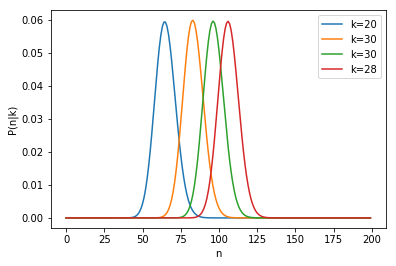

In [100]:
%matplotlib inline

r = 50
nMax = 200

rv = stats.poisson(r)

nPMF = [rv.pmf(x) for x in range(nMax)]

#plt.plot(range(nMax), nPMF, label='PMF')
#plt.show()

# Likelihood of observing k on the Geiger counter 
# given that the true count is h
# Assume that f is the fraction of partiticles that gets counted 
def Likelihood_n(k,h):
    f = .1
    return stats.binom.pmf(k,h,f)

# Bayesian update given that the counter observed k particles
def update_n(hpmf,k):
    total = 0.0
    # multiply prior by likelihood
    for h in range(nMax):
        hpmf[h] *= Likelihood_n(k,h)
        total += hpmf[h]
    # normalize to sum to 1.0
    for h in range(nMax):
        hpmf[h] /= total
        
for k in (20,30,30,28):
    print('Observing k = ' + str(k))
    update_n(nPMF, k)
    plt.plot(range(nMax), nPMF, label='k='+str(k))
    print('MAP estimate for n = ' + str(np.argmax(nPMF)))

plt.ylabel('P(n|k)')
plt.xlabel('n')
plt.legend()
plt.show()

## Hierarchical Model

We only observe the Geiger counts and we want to find the emission rate r - both r and n are unknown.

In [99]:
rMax = 60

print('Initializing PMF for r and n...')
rPMF = [1.0/rMax for x in range(rMax)]
nPMF_r = []
for r in range(rMax):
    nPMF_r.append([stats.poisson.pmf(x,r) for x in range(nMax)])

# Likelihood of Geiger counter observing k particles given emission rate is h
def Likelihood_r(k,r):
    total = 0.0
    nPMF = nPMF_r[r]
    for n in range(nMax):
        total += nPMF[n] * Likelihood_n(k,n)
    return total

def update_r(rpmf,k):
    total = 0.0
    # multiply prior by likelihood
    for r in range(rMax):
        update_n(nPMF_r[r],k)
        rpmf[r] *= Likelihood_r(k,r)
        total += rpmf[r]
    # normalize to sum to 1.0
    for r in range(rMax):
        rpmf[r] /= total

for k in (4,3):
    print('Observe k = ' + str(k))
    update_r(rPMF,k)
    print('MAP estimate for r = ' + str(np.argmax(rPMF)))


Initializing PMF for r and n...
Observe k = 4


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


MAP estimate for r = 0
Observe k = 3
MAP estimate for r = 0


Why did we get zeroes?

--- Testing the estimation of n ---
Observing k = 20
MAP estimate for n = 64
Observing k = 30
MAP estimate for n = 83
Observing k = 30
MAP estimate for n = 96
Observing k = 28
MAP estimate for n = 106
Initializing Log PMF for r and n...
Observe k = 4
MAP estimate for r = 40
Observe k = 3
MAP estimate for r = 35


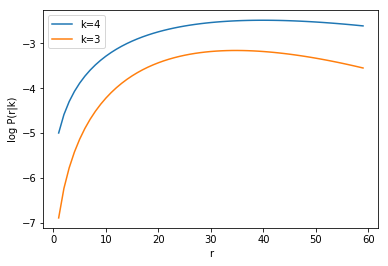

In [101]:
# Log-Likelihood version without normalization
from math import log10, inf, pow

# my log function for probabilities that handle zero gracefully 
def mylog(p):
    if p==0:
        return -math.inf
    return log10(p)

def mypow(lp):
    if lp == -math.inf:
        return 0
    return pow(10,lp)

r = 50
nMax = 200

nLPMF = [mylog(stats.poisson.pmf(x,r)) for x in range(nMax)]

#pprint.pprint(nPMF)

#plt.plot(range(nMax), nPMF, label='PMF')
#plt.show()

# Likelihood of observing k on the Geiger counter 
# given that the true count is h
# Assume that f is the fraction of partiticles that gets counted 
def LogLikelihood_n(k,h):
    f = .1
    return mylog(stats.binom.pmf(k,h,f))

# Bayesian update given that the counter observed k particles
def LogUpdate_n(hlpmf,k):
    # multiply prior by likelihood
    total = 0.0
    for h in range(nMax):
        hlpmf[h] += LogLikelihood_n(k,h)
        total += mypow(hlpmf[h])
    scale = mylog(total)
    for h in range(nMax):
        hlpmf[h] -= scale

print('--- Testing the estimation of n ---')
for k in (20,30,30,28):
    print('Observing k = ' + str(k))
    LogUpdate_n(nLPMF, k)
    print('MAP estimate for n = ' + str(np.argmax(nLPMF)))

# --------------------
# Hierarchical Model
# --------------------

rMax = 60

print('Initializing Log PMF for r and n...')
rLPMF = [mylog(1.0/rMax) for x in range(rMax)]
nLPMF_r = []
for r in range(rMax):
    nLPMF_r.append([mylog(stats.poisson.pmf(x,r)) for x in range(nMax)])

# Likelihood of Geiger counter observing k particles given emission rate is h
def LogLikelihood_r(k,r):
    total = 0.0
    nLPMF = nLPMF_r[r]
    #l=[]
    for n in range(nMax):
        ll = LogLikelihood_n(k,n)
        lp = nLPMF[n] + ll
        total += mypow(lp)
    #    l.append(lp)
    #plt.plot(range(nMax),nLPMF)
    #plt.plot(range(nMax),l)
    return mylog(total)

def LogUpdate_r(rlpmf,k):
    total = 0.0
    # multiply prior by likelihood
    for r in range(rMax):
        LogUpdate_n(nLPMF_r[r],k)
        ll = LogLikelihood_r(k,r)
        #print(ll)
        rlpmf[r] += ll
        
#        total += mypow(rlpmf[r])
#    scale = mylog(total)
#    for r in range(rMax):
#        rlpmf[r] -= scale

def argmax(ll):
    curmaxi=-1
    curmax=-math.inf
    i=0
    for x in ll:
        if x>=curmax:
            curmaxi=i
            curmax=x
        i+=1
    return curmaxi

for k in (4,3):
    print('Observe k = ' + str(k))
    #print(LogLikelihood_r(k,40))
    #print(LogLikelihood_r(k,30))
    LogUpdate_r(rLPMF,k)
    plt.plot(range(rMax), rLPMF, label='k='+str(k))
    print('MAP estimate for r = ' + str(argmax(rLPMF)))

# convert PMF in log probabilities back to probabilities
def logPMF2PMF(lpmf):
    pmf = []
    for lp in lpmf:
        pmf.append(mypow(lp))
    return pmf

#plt.plot(range(rMax), logPMF2PMF(rPMF))
#plt.plot(range(rMax), rLPMF)

plt.ylabel('log P(r|k)')
plt.xlabel('r')
plt.legend()
plt.show()